In [1]:
!pip -q install understatapi tqdm matplotlib scikit-learn pandas numpy

In [2]:
from understatapi import UnderstatClient
import pandas as pd
import numpy as np
from math import hypot
from time import sleep
from tqdm.auto import tqdm
import json
from pprint import pprint

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [3]:
LEAGUE = "EPL"    # "EPL", "La_Liga", "Bundesliga", "Serie_A", "Ligue_1", "RFPL"
SEASON = "2024"

In [5]:
def get_league_match_ids(league: str, season: str):
    """Retorna lista de de match_ids por liga y temporada."""
    with UnderstatClient() as us:
        matches = us.league(league=league).get_match_data(season=season)
    return [m["id"] for m in matches], matches

match_ids, raw_matches = get_league_match_ids(LEAGUE, SEASON)
print(f"Total de matches encontrados: {len(match_ids)}")
print("Ejemplos de match_ids:", match_ids[:10])

print("\nEjemplo de cómo viene un match:")
pprint({k: raw_matches[0][k] for k in list(raw_matches[0].keys())[:10]})

Total de matches encontrados: 380
Ejemplos de match_ids: ['26602', '26603', '26604', '26605', '26606', '26607', '26608', '26609', '26610', '26611']

Ejemplo de cómo viene un match:
{'a': {'id': '228', 'short_title': 'FLH', 'title': 'Fulham'},
 'datetime': '2024-08-16 19:00:00',
 'forecast': {'d': '0.1489', 'l': '0.0442', 'w': '0.8069'},
 'goals': {'a': '0', 'h': '1'},
 'h': {'id': '89', 'short_title': 'MUN', 'title': 'Manchester United'},
 'id': '26602',
 'isResult': True,
 'xG': {'a': '0.418711', 'h': '2.04268'}}


In [6]:
# METODOS de obtención y formateo de datos Optimizados
def fetch_match_shots(match_id: str, client: UnderstatClient) -> list[dict]:
    out = []
    md = client.match(match=match_id).get_shot_data()
    for side in ("h", "a"):
        for s in md.get(side, []):
            s = dict(s)  # copy
            s["h_a"] = side
            s["match_id"] = match_id
            out.append(s)
    return out

def shots_to_df(shots: list[dict]) -> pd.DataFrame:
    rows = []
    for s in shots:
        rows.append({
            "match_id": s.get("match_id"),
            "minute": int(s.get("minute")),
            "team": s.get("h_team") if s.get("h_a") == "h" else s.get("a_team"),
            "h_a": s.get("h_a"),
            "player": s.get("player"),
            "result": s.get("result"),             
            "X": float(s.get("X")),                
            "Y": float(s.get("Y")),                
            "is_goal": 1 if s.get("result") == "Goal" else 0,
        })
    df = pd.DataFrame(rows)
    return df.dropna(subset=["X", "Y"]).reset_index(drop=True)

In [7]:
all_shots = []
with UnderstatClient() as us:
    for mid in tqdm(match_ids, desc=f"Descargando tiros {LEAGUE} {SEASON}"):
        try:
            all_shots.extend(fetch_match_shots(mid, us))
        except Exception:
            pass
        sleep(0.15)

len(all_shots)

Descargando tiros EPL 2024:   0%|          | 0/380 [00:00<?, ?it/s]

9878

In [8]:
# --- Dataframe preview ---
df_raw = shots_to_df(all_shots)
print("Rows:", len(df_raw))
df_raw.sample(8).sort_values(["match_id","minute"]).head(8)


Rows: 9878


,match_id,minute,team,h_a,player,result,X,Y,is_goal
1390,26655,12,Arsenal,h,Jurriën Timber,BlockedShot,0.893,0.291,0
1706,26666,35,Arsenal,h,Gabriel,MissedShots,0.722,0.507,0
2658,26697,64,Manchester United,h,Alejandro Garnacho,SavedShot,0.878,0.434,0
3452,26726,30,Liverpool,h,Trent Alexander-Arnold,BlockedShot,0.787,0.368,0
6769,26857,12,Tottenham,a,Lucas Bergvall,BlockedShot,0.847,0.670,0
7629,26894,79,Manchester United,a,Mason Mount,MissedShots,0.808,0.507,0
8737,26940,34,Fulham,a,Willian,BlockedShot,0.831,0.665,0
9773,26978,29,Wolverhampton Wanderers,h,Matheus Cunha,SavedShot,0.729,0.546,0


In [9]:
# --- Estandarizar coordenadas ---
def standardize_shot_coordinates(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    mask = out["X"] < 0.5
    out.loc[mask, "X"] = 1 - out.loc[mask, "X"]
    out.loc[mask, "Y"] = 1 - out.loc[mask, "Y"]
    return out

df_std = standardize_shot_coordinates(df_raw)


In [10]:
# --- Distancia en metros (100 x 65 Tamaño de una cancha de fútbol promedio) ---------------------
PITCH_LENGTH_M = 100.0
PITCH_WIDTH_M  = 65.0

def add_distance_m(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    xm = out["X"] * PITCH_LENGTH_M
    ym = out["Y"] * PITCH_WIDTH_M
    out["distance_m"] = np.hypot(PITCH_LENGTH_M - xm, (PITCH_WIDTH_M/2) - ym)
    return out

df_dist = add_distance_m(df_std)

print("Filas:", df_dist.shape[0])
print("Rango de distance_m:", float(df_dist["distance_m"].min()), float(df_dist["distance_m"].max()))
print("Goles y No Goles:", df_dist["is_goal"].value_counts().to_dict())
assert "distance_m" in df_dist.columns
df_dist.head(5)

Filas: 9878
Rango de distance_m: 0.8000030517578125 50.004201871157036
Goles y No Goles: {0: 8797, 1: 1081}


,match_id,minute,team,h_a,player,result,X,Y,is_goal,distance_m
0,26602,19,Manchester United,h,Bruno Fernandes,MissedShots,0.971,0.673,0,11.612927
1,26602,26,Manchester United,h,Casemiro,MissedShots,0.747,0.479,0,25.336799
2,26602,28,Manchester United,h,Bruno Fernandes,SavedShot,0.913,0.346,0,13.262355
3,26602,33,Manchester United,h,Bruno Fernandes,SavedShot,0.913,0.463,0,9.026293
4,26602,36,Manchester United,h,Casemiro,MissedShots,0.958,0.599,0,7.684349


In [12]:
BIN_WIDTH = 1.0
ALPHA = 1.0

bins = np.arange(0.0, np.ceil(df_dist["distance_m"].max()) + BIN_WIDTH, BIN_WIDTH)
df_dist["dist_bin"] = pd.cut(df_dist["distance_m"], bins=bins, right=False)

bin_stats = (df_dist
    .groupby("dist_bin", observed=True)
    .agg(
        shots=("is_goal", "size"),
        goals=("is_goal", "sum"),
        d_min=("distance_m", "min"),
        d_max=("distance_m", "max")
    )
    .dropna(subset=["d_min", "d_max"])
    .reset_index(drop=True)
)

bin_stats["d_mid"]  = 0.5 * (bin_stats["d_min"] + bin_stats["d_max"])
bin_stats["p_goal"] = (bin_stats["goals"] + ALPHA) / (bin_stats["shots"] + 2*ALPHA)


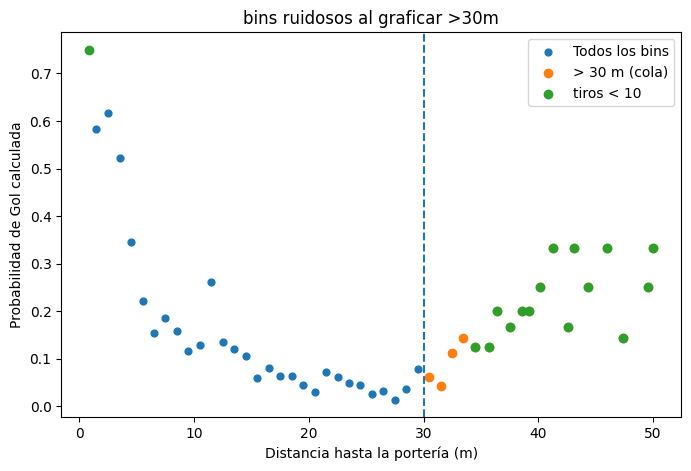

In [13]:
# Muestra dispersión de rango completo con colores para colas "ruidosas" y bins de muestra bajos
import matplotlib.pyplot as plt
import numpy as np

LOW_N = 10
CUT_MAX = 30
CUT_MIN = 2

tail_mask = bin_stats["d_mid"] > CUT_MAX
lown_mask = bin_stats["shots"] < LOW_N

plt.figure(figsize=(8,5))
plt.scatter(bin_stats["d_mid"], bin_stats["p_goal"], s=24, label="Todos los bins")
plt.scatter(bin_stats.loc[tail_mask, "d_mid"],
            bin_stats.loc[tail_mask, "p_goal"], s=36, label=f"> {CUT_MAX} m (cola)")
plt.scatter(bin_stats.loc[lown_mask, "d_mid"],
            bin_stats.loc[lown_mask, "p_goal"], s=36, label=f"tiros < {LOW_N}")
plt.axvline(CUT_MAX, ls="--", lw=1.5)
plt.xlabel("Distancia hasta la portería (m)")
plt.ylabel("Probabilidad de Gol calculada")
plt.title("bins ruidosos al graficar >30m")
plt.legend()
plt.show()


In [14]:
# Cuantificamos porqué los bins son ruidosos
share_tail = (df_dist["distance_m"] > CUT_MAX).mean()
shots_tail = int((df_dist["distance_m"] > CUT_MAX).sum())
print(f"Tiros más allá de {CUT_MAX} m: {shots_tail} ({share_tail:.1%} de todos los tiros)")

# Mostrar los peores: bins con p alto pero tamaños de muestra pequeños o distancias muy largas
display_cols = ["d_mid", "shots", "goals", "p_goal"]
tail_preview = (bin_stats[tail_mask | lown_mask]
                .sort_values(["d_mid", "shots"], ascending=[True, True])
                [display_cols].head(12))
tail_preview


Tiros más allá de 30 m: 182 (1.8% de todos los tiros)


,d_mid,shots,goals,p_goal
0,0.877077,2,2,0.750000
30,30.510755,64,3,0.060606
31,31.496598,46,1,0.041667
32,32.470218,16,1,0.111111
33,33.399540,12,1,0.142857
34,34.456441,6,0,0.125000
35,35.670500,6,0,0.125000
36,36.436393,3,0,0.200000
37,37.495400,4,0,0.166667
38,38.534887,3,0,0.200000


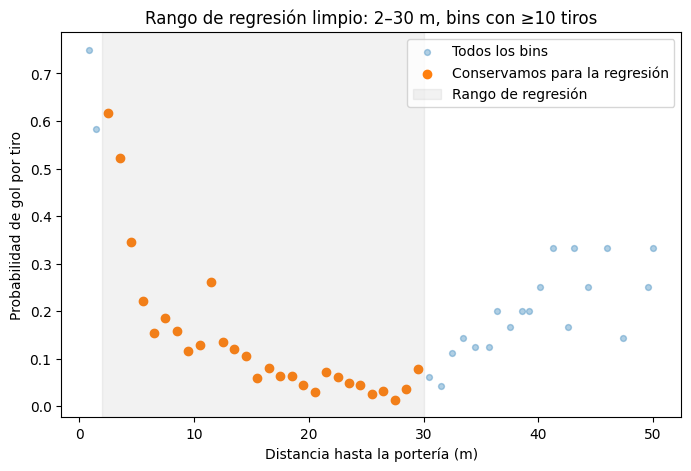

In [15]:
# 3) Now show the cleaned view you'll fit on (2–30 m, shots >= 10)
fit_bins = bin_stats[(bin_stats["shots"] >= LOW_N) &
                     (bin_stats["d_mid"] >= CUT_MIN) &
                     (bin_stats["d_mid"] <= CUT_MAX)]

plt.figure(figsize=(8,5))
plt.scatter(bin_stats["d_mid"], bin_stats["p_goal"], s=18, alpha=0.35, label="Todos los bins")
plt.scatter(fit_bins["d_mid"], fit_bins["p_goal"], s=36, label="Conservamos para la regresión")
plt.axvspan(CUT_MIN, CUT_MAX, color="grey", alpha=0.1, label="Rango de regresión")
plt.xlabel("Distancia hasta la portería (m)")
plt.ylabel("Probabilidad de gol por tiro")
plt.title("Rango de regresión limpio: 2–30 m, bins con ≥10 tiros")
plt.legend()
plt.show()


In [16]:
# ------------------------------
# 1. Modelo Bernoulli
# ------------------------------
# Cada tiro es un experimento de Bernoulli:
#   Y_i ~ Bernoulli(p_i)
# donde:
#   p_i = a * (d_i ** b)
#   d_i = distancia del tiro en metros
#   a, b = parámetros a estimar

# ------------------------------
# 2. Verosimilitud
# ------------------------------
# L(a,b) = ∏ [p_i^(y_i) * (1 - p_i)^(1 - y_i)]
# donde:
#   y_i = 1 si gol, 0 si no gol

# ------------------------------
# 3. Log-verosimilitud
# ------------------------------
# ℓ(a,b) = Σ [y_i * log(p_i) + (1 - y_i) * log(1 - p_i)]
# Usamos log para evitar underflow numérico (productos muy pequeños).

# ------------------------------
# 4. Máxima Verosimilitud (MLE)
# ------------------------------
# Queremos encontrar (a, b) que MAXIMICEN ℓ(a,b).
# Como scipy.optimize.minimize() minimiza, usamos la negativa:
#   NegLogLik(a,b) = -ℓ(a,b)
#   (a_MLE, b_MLE) = argmin_{a,b} NegLogLik(a,b)


In [17]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import r2_score

distances = df_dist["distance_m"].values.astype(float)
goals = df_dist["is_goal"].values.astype(int)

print("Tiros:", distances.shape[0], "| Goles:", goals.sum())


Tiros: 9878 | Goles: 1081


In [18]:
def neg_log_likelihood(params, d, y):
    """log-verosimilitud Negativa de Bernoulli con p = a * d^b."""
    a, b = params
    p = a * (d ** b)
    p = np.clip(p, 1e-9, 1 - 1e-9)
    ll = y * np.log(p) + (1 - y) * np.log(1 - p)
    return -np.sum(ll)

try:
    start_a = float(a_hat); start_b = float(b_hat)
except NameError:
    start_a, start_b = 1.0, -1.0

start_a, start_b

(1.0, -1.0)

In [19]:
res = minimize(
    neg_log_likelihood,
    x0=[start_a, start_b],
    args=(distances, goals),
    method="L-BFGS-B",
    bounds=[(1e-9, None), (None, None)]
)

a_mle, b_mle = res.x
print(f"MLE fit: a = {a_mle:.6f}, b = {b_mle:.6f}")

MLE fit: a = 1.138576, b = -0.936073


In [20]:
p_pred = np.clip(a_mle * (distances ** b_mle), 1e-9, 1 - 1e-9)

r2_shot_mle = r2_score(goals, p_pred)
brier = np.mean((p_pred - goals)**2)

print(f"R² (nivel de tiro, MLE) = {r2_shot_mle:.3f}")
print(f"Brier score (nivel de tiro) = {brier:.4f}")

R² (nivel de tiro, MLE) = 0.066
Brier score (nivel de tiro) = 0.0910


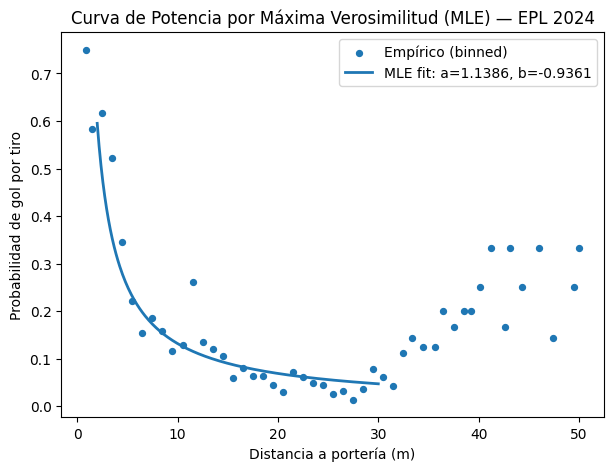

In [21]:
import matplotlib.pyplot as plt

d_grid = np.linspace(2, 30, 300)
p_fit_mle = a_mle * (d_grid ** b_mle)

plt.figure(figsize=(7,5))
plt.scatter(bin_stats["d_mid"], bin_stats["p_goal"], s=18, label="Empírico (binned)")
plt.plot(d_grid, p_fit_mle, lw=2, label=f"MLE fit: a={a_mle:.4f}, b={b_mle:.4f}")
plt.xlabel("Distancia a portería (m)")
plt.ylabel("Probabilidad de gol por tiro")
plt.title(f"Curva de Potencia por Máxima Verosimilitud (MLE) — {LEAGUE} {SEASON}")
plt.legend()
plt.show()

In [22]:
def powercurve_xg(distance_m: float, a: float, b: float) -> float:
    """Goles esperados para un tiro dado distancia en metros."""
    d = max(float(distance_m), 0.5)  # guard near-zero distances
    return a * (d ** b)

df_dist["xg_mle"] = np.clip(
    df_dist["distance_m"].apply(lambda d: powercurve_xg(d, a_mle, b_mle)),
    1e-9, 1 - 1e-9
)

# Agrupamos por partido-equipo
team_match_xg_mle = (
    df_dist.groupby(["match_id", "team"], as_index=False)
           .agg(shots=("is_goal", "size"),
                goals=("is_goal", "sum"),
                xg_sum=("xg_mle", "sum"))
)

# Agrupamos por temporada-equipo
team_season_xg_mle = (
    team_match_xg_mle.groupby("team", as_index=False)
                     .agg(matches=("match_id","nunique"),
                          shots=("shots","sum"),
                          goals=("goals","sum"),
                          xg=("xg_sum","sum"))
)
team_season_xg_mle["residual"] = team_season_xg_mle["goals"] - team_season_xg_mle["xg"]

# Errors
rmse_season = np.sqrt(np.mean((team_season_xg_mle["goals"] - team_season_xg_mle["xg"])**2))
mae_season  = np.mean(np.abs(team_season_xg_mle["goals"] - team_season_xg_mle["xg"]))

rmse_match = np.sqrt(np.mean((team_match_xg_mle["goals"] - team_match_xg_mle["xg_sum"])**2))
mae_match  = np.mean(np.abs(team_match_xg_mle["goals"] - team_match_xg_mle["xg_sum"]))

print(f"RMSE de la Temporada={rmse_season:.2f}, MAE={mae_season:.2f}")
print(f"RMSE Partido-equipo={rmse_match:.2f}, MAE={mae_match:.2f}")

# Local vs Visitante xG por Partido (para uso en pre-partido)
home_away_xg_mle = (
    df_dist.groupby(["team","h_a"], as_index=False)
           .agg(matches=("match_id","nunique"),
                goals=("is_goal","sum"),
                xg=("xg_mle","sum"))
)
home_away_xg_mle["xg_per_match"] = home_away_xg_mle["xg"] / home_away_xg_mle["matches"]

home_away_pivot_mle = home_away_xg_mle.pivot(index="team", columns="h_a", values="xg_per_match")
home_away_pivot_mle.columns = ["away_xg_per_match", "home_xg_per_match"]
home_away_pivot_mle = home_away_pivot_mle.reset_index()

home_away_pivot_mle


RMSE de la Temporada=7.70, MAE=6.76
RMSE Partido-equipo=1.12, MAE=0.87


,team,away_xg_per_match,home_xg_per_match
0,Arsenal,1.536934,1.821713
1,Aston Villa,1.072504,1.688212
2,Bournemouth,1.623498,1.655339
3,Brentford,1.157420,1.672281
4,Brighton,1.325343,1.532583
5,Chelsea,1.413500,1.816031
6,Crystal Palace,1.430807,1.595641
7,Everton,0.990446,1.213941
8,Fulham,1.464132,1.411094
9,Ipswich,1.032891,1.020989
